In [1]:
from pynq import Overlay
overlay = Overlay('overlay/top_paper_bd.bit')

In [2]:
from pynq import MMIO

In [3]:
N_DTPS = 5
N_LABELS = 5
CLASSES = [1,2,3,4,5]

REGSBANK_BASE_ADDRESS=0x43C0_0000
REGSBANK_ADDRESS_RANGE=64*1024

SAMPLE_BRAM_BASE_ADDRESS = 0xC005_0000
SAMPLE_BRAM_ADDRESS_RANGE = 32*1024

DTP_BRAM_BASE_ADDRESS = [0xC000_0000, 0xC001_0000, 0xC002_0000, 0xC003_0000, 0xC004_0000]
DTP_BRAM_ADDRESS_RANGE = [64*1024, 64*1024, 64*1024, 64*1024, 64*1024]

INPUT_BUFFER_BASE_ADDRESS = DTP_BRAM_BASE_ADDRESS[0]
INPUT_BUFFER_ADDRESS_RANGE = DTP_BRAM_ADDRESS_RANGE[0]*N_DTPS + SAMPLE_BRAM_ADDRESS_RANGE

VOTE_BRAM_BASE_ADDRESS = 0xC00C_0000
VOTE_BRAM_ADDRESS_RANGE = 32*1024

In [4]:
regsbank_mmio = MMIO(REGSBANK_BASE_ADDRESS, REGSBANK_ADDRESS_RANGE)

In [5]:
from enum import IntEnum
import time
from pynq import allocate
import numpy as np

In [6]:
def getbit(value, order):
    orderVal = 2**order
    tmpbin = value & orderVal
    if (tmpbin):
        return 1
    else:
        return 0

def changebit(value, order, bit):
    if (bit == 1):
        return value | (1 << order)
    else:
        return value & ~(1 << order)

class Cdma(IntEnum):
    CDMACR = 0x0
    CDMASR = 0x4
    SA = 0x18
    DA = 0x20
    BTT = 0x28

def transfer(cdma, src, dst, size):
    # Step 1
    cdmasr = cdma.read(Cdma.CDMASR)
    cdmasrIdle = getbit(cdmasr, 1)
    if (cdmasrIdle != 1):
#         print("CDMA is busy..")
        return

    # Step 2
    cdmacr = cdma.read(Cdma.CDMACR)
    cdmacr = changebit(cdmacr, 12, 1) # set IOC_IrqEn
    cdmacr = changebit(cdmacr, 14, 1) # set ERR_IrqEn
    cdma.write(Cdma.CDMACR, cdmacr)

    # Step 3
    cdma.write(Cdma.SA, src)

    # Step 4
    cdma.write(Cdma.DA, dst)

    # Step 5
    cdma.write(Cdma.BTT, size)

    # Step 6
#     print("Transferring...")
    cdma.read(Cdma.CDMASR)
    cdmasrIdle = getbit(cdmasr, 1)
    while (cdmasrIdle != 1):
#         print(".", end="")
        cdma.read(Cdma.CDMASR)
        cdmasrIdle = getbit(cdmasr, 1)

    # Step 7-8
    cdmasr = cdma.read(Cdma.CDMASR)
    cdmasr = changebit(cdmasr, 12, 1) # clear IOC_Irq
    cdma.write(Cdma.CDMASR, cdmasr)

#     print("Transfered " + str(size) + " bytes from " + str(src) + " to " + str(dst))
#     print("CDMA Done.")

def reset(cdma):
    cdmacr = cdma.read(Cdma.CDMACR)
    print(type(cdmacr))
    print(cdmacr)
    cdmacr = changebit(cdmacr, 2, 1)
    print(cdmacr)
    cdma.write(Cdma.CDMACR, cdmacr)

In [7]:
# registers
CTRL_REG_IDX = 0
STT_REG_IDX = 1
SAMP_THSH_REG_IDX = 2
N_ATTRS_REG_IDX = 3

CTRL_REG_START_CORE_IDX     = 0 # start the core. Converted to POSEDGE PULSE
CTRL_REG_END_CORE_IDX       = 1 # end the core, clear DTP_FIN bit in STT_REG. Converted to POSEDGE PULSE
CTRL_REG_THSH_VLD_IDX       = 2 # VLD signal with SAMP_THSH_REG. Converted to POSEDGE PULSE
CTRL_REG_THSH_CLR_IDX       = 3 # CLEAR signal for THSH_DONE bit in STT_REG
CTRL_REG_TREE_RAM_READY_IDX = 4 # READY signal for DTP Tree RAM
CTRL_REG_IS_PS_READ_IDX     = 5 # READ signal to read vote bram
CTRL_REG_IS_CLF_IDX         = 6 # signal to indicate if it is classification

ctrl_bit_name = ['CTRL_REG_START_CORE_IDX', 'CTRL_REG_END_CORE_IDX', 'CTRL_REG_THSH_VLD_IDX', 'CTRL_REG_THSH_CLR_IDX', 'CTRL_REG_TREE_RAM_READY_IDX', 'CTRL_REG_IS_PS_READ_IDX', 'CTRL_REG_IS_CLF_IDX']

STT_REG_DTP_FIN_IDX         = 0 # 1: core is finish
STT_REG_THSH_DONE_IDX       = 1 # 1: threshold in sample FIFO is completely set

stt_bit_name = ['STT_REG_DTP_FIN_IDX', 'STT_REG_THSH_DONE_IDX']


# parameters
N_ATTR = 7
N_SAMPLE = 144

In [8]:
def write_bit(mmio, addr, order, bit):
    read_data = mmio.read(addr)
    mmio.write(addr, changebit(read_data, order, bit))
    
def read_bit(mmio, addr, order):
    return getbit(mmio.read(addr),order)
    

In [9]:
def print_reg():
    ctrl_reg = regsbank_mmio.read(4*CTRL_REG_IDX)
    print('ctrl_reg: ', ctrl_reg)
    for i in range(len(ctrl_bit_name)):
        print(ctrl_bit_name[i]+': ', read_bit(regsbank_mmio,4*CTRL_REG_IDX,i))

    print('')

    stt_reg = regsbank_mmio.read(4*STT_REG_IDX)
    print('stt_reg: ', stt_reg)
    for i in range(len(stt_bit_name)):
        print(stt_bit_name[i]+': ', read_bit(regsbank_mmio,4*STT_REG_IDX,i))

    print('')

    print('samp_thsh_reg: ', regsbank_mmio.read(4*SAMP_THSH_REG_IDX))
    print('n_attrs_reg: ', regsbank_mmio.read(4*N_ATTRS_REG_IDX))

In [10]:
print_reg()

ctrl_reg:  0
CTRL_REG_START_CORE_IDX:  0
CTRL_REG_END_CORE_IDX:  0
CTRL_REG_THSH_VLD_IDX:  0
CTRL_REG_THSH_CLR_IDX:  0
CTRL_REG_TREE_RAM_READY_IDX:  0
CTRL_REG_IS_PS_READ_IDX:  0
CTRL_REG_IS_CLF_IDX:  0

stt_reg:  0
STT_REG_DTP_FIN_IDX:  0
STT_REG_THSH_DONE_IDX:  0

samp_thsh_reg:  0
n_attrs_reg:  0


In [11]:
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_TREE_RAM_READY_IDX, 1)
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_CLF_IDX, 1)

regsbank_mmio.write(4*SAMP_THSH_REG_IDX, (N_ATTR*N_SAMPLE)-1)
regsbank_mmio.write(4*N_ATTRS_REG_IDX, N_ATTR-1)

In [12]:
import time

# LOAD DATA FROM FILES

In [13]:
def samplefile_2_buffer(filename, buffer_size):
    sample_buffer = []
    with open(filename,'r') as f:
        for sample in f:
            attr_list = sample.split()
            for attr in attr_list:
                sample_buffer.append(int(attr))
    sample_buffer.extend([0]*(buffer_size-len(sample_buffer))) 
    return np.array(sample_buffer, dtype=np.uint32)

def dtpfile_2_buffer(filename, dtp_size):
    dtp_buffer = []
    with open(filename,'r') as f:
        for dtp in f:
            node_buffer = []
            node_list = dtp.split()
            for node in node_list:
                node_buffer.append(int(node))
            node_buffer.extend([0]*(dtp_size-len(node_buffer)))
            dtp_buffer.extend(node_buffer)
    return np.array(dtp_buffer, dtype=np.uint32)

In [14]:
sample_buffer = samplefile_2_buffer('land_samples_mem.txt', SAMPLE_BRAM_ADDRESS_RANGE//4)
dtp_buffer = dtpfile_2_buffer('land_forest_mem_5dtp.txt', DTP_BRAM_ADDRESS_RANGE[0]//4)
print(len(sample_buffer), len(dtp_buffer))

8192 81920


In [52]:
sample_buffer

array([24938, 25342, 25674, ...,     0,     0,     0], dtype=uint32)

# PREPARE CDMA

In [16]:
cdma = overlay.axi_cdma_0

In [17]:
dtp_buffer_cdma_in = allocate(shape=(DTP_BRAM_ADDRESS_RANGE[0]//4*N_DTPS,), dtype=np.uint32) # input buffer for all DTPs
dtp_buffer_cdma_in[:] = dtp_buffer

In [18]:
# dtp_idx = 0
# for i in range(DTP_BRAM_ADDRESS_RANGE[dtp_idx]//4*dtp_idx, DTP_BRAM_ADDRESS_RANGE[dtp_idx]//4*(dtp_idx+1)):
#     print(i, dtp_buffer_cdma_in[i])

In [19]:
dtp_buffer_cdma_out = allocate(shape=(DTP_BRAM_ADDRESS_RANGE[0]//4*N_DTPS,), dtype=np.uint32) 

In [20]:
print("==== READ CDMA ====")

# start_time = time.time()
transfer(cdma, DTP_BRAM_BASE_ADDRESS[0], dtp_buffer_cdma_out.physical_address, DTP_BRAM_ADDRESS_RANGE[0]*N_DTPS) # transfer to all DTPs
# end_time = time.time()

==== READ CDMA ====


In [21]:
# dtp_idx = 0
# for i in range(DTP_BRAM_ADDRESS_RANGE[dtp_idx]//4*dtp_idx, DTP_BRAM_ADDRESS_RANGE[dtp_idx]//4*(dtp_idx+1)):
#     print(i, dtp_buffer_cdma_out[i])

In [22]:
def compare_buffer(b1,b2):
    if(len(b1)!= len(b2)):
        print('len diff:', len(b1), len(b2))
        return False
    for i in range(len(b1)):
        if b1[i] != b2[i]:
            print(i,b1[i],b2[i])
            return False
    return True

print(compare_buffer(dtp_buffer_cdma_in, dtp_buffer_cdma_out))

True


In [23]:
sample_buffer_in = allocate(shape=(SAMPLE_BRAM_ADDRESS_RANGE//4,), dtype=np.uint32)
sample_buffer_in[:] = sample_buffer
# sample_buffer_in[:len(sample_partitions[0])] = sample_partitions[0]

In [24]:
sample_buffer_out = allocate(shape=(SAMPLE_BRAM_ADDRESS_RANGE//4,), dtype=np.uint32)

In [25]:
transfer(cdma, SAMPLE_BRAM_BASE_ADDRESS, sample_buffer_out.physical_address, SAMPLE_BRAM_ADDRESS_RANGE)

In [26]:
# transfer(cdma, sample_buffer_in.physical_address, SAMPLE_BRAM_BASE_ADDRESS, SAMPLE_BRAM_ADDRESS_RANGE)

In [27]:
# for i in range(SAMPLE_BRAM_ADDRESS_RANGE//4):
#     print(i, sample_buffer_out[i])

In [28]:
print(compare_buffer(sample_buffer_in, sample_buffer_out))

True


In [29]:
input_buffer = allocate(shape=(INPUT_BUFFER_ADDRESS_RANGE//4,), dtype=np.uint32)
input_buffer[:len(dtp_buffer_cdma_in)] = dtp_buffer_cdma_in
input_buffer[len(dtp_buffer_cdma_in):] = sample_buffer_in

In [30]:
vote_buffer_cdma_out = allocate(shape=(VOTE_BRAM_ADDRESS_RANGE//4,), dtype=np.uint32)

In [31]:
print("==== READ CDMA ====")
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 1) # reading mode ON
# start_time = time.time()
transfer(cdma, VOTE_BRAM_BASE_ADDRESS, vote_buffer_cdma_out.physical_address, VOTE_BRAM_ADDRESS_RANGE) # transfer to all DTPs
# end_time = time.time()
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 0) # reading mode OFF

==== READ CDMA ====


In [57]:
idx=0
for i in range(VOTE_BRAM_ADDRESS_RANGE//4):
    if idx%N_LABELS==0:
        print('sample',idx//N_LABELS,'---------------------------')
    print(vote_buffer_cdma_out[i])
    idx+=1

sample 0 ---------------------------
0
0
0
1348
152
sample 1 ---------------------------
81
1390
21
7
1
sample 2 ---------------------------
1434
0
66
0
0
sample 3 ---------------------------
1500
0
0
0
0
sample 4 ---------------------------
1500
0
0
0
0
sample 5 ---------------------------
10
0
1490
0
0
sample 6 ---------------------------
0
12
1484
4
0
sample 7 ---------------------------
0
0
1500
0
0
sample 8 ---------------------------
1236
0
264
0
0
sample 9 ---------------------------
0
1
1495
4
0
sample 10 ---------------------------
1500
0
0
0
0
sample 11 ---------------------------
0
0
0
1500
0
sample 12 ---------------------------
0
0
1
1497
2
sample 13 ---------------------------
0
0
1497
3
0
sample 14 ---------------------------
5
0
0
1495
0
sample 15 ---------------------------
1500
0
0
0
0
sample 16 ---------------------------
103
0
1397
0
0
sample 17 ---------------------------
1500
0
0
0
0
sample 18 ---------------------------
54
1409
27
9
1
sample 19 ------------------

0
0
0
0
0
sample 168 ---------------------------
0
0
0
0
0
sample 169 ---------------------------
0
0
0
0
0
sample 170 ---------------------------
0
0
0
0
0
sample 171 ---------------------------
0
0
0
0
0
sample 172 ---------------------------
0
0
0
0
0
sample 173 ---------------------------
0
0
0
0
0
sample 174 ---------------------------
0
0
0
0
0
sample 175 ---------------------------
0
0
0
0
0
sample 176 ---------------------------
0
0
0
0
0
sample 177 ---------------------------
0
0
0
0
0
sample 178 ---------------------------
0
0
0
0
0
sample 179 ---------------------------
0
0
0
0
0
sample 180 ---------------------------
0
0
0
0
0
sample 181 ---------------------------
0
0
0
0
0
sample 182 ---------------------------
0
0
0
0
0
sample 183 ---------------------------
0
0
0
0
0
sample 184 ---------------------------
0
0
0
0
0
sample 185 ---------------------------
0
0
0
0
0
sample 186 ---------------------------
0
0
0
0
0
sample 187 ---------------------------
0
0
0
0
0
sample 188

0
0
0
0
sample 347 ---------------------------
0
0
0
0
0
sample 348 ---------------------------
0
0
0
0
0
sample 349 ---------------------------
0
0
0
0
0
sample 350 ---------------------------
0
0
0
0
0
sample 351 ---------------------------
0
0
0
0
0
sample 352 ---------------------------
0
0
0
0
0
sample 353 ---------------------------
0
0
0
0
0
sample 354 ---------------------------
0
0
0
0
0
sample 355 ---------------------------
0
0
0
0
0
sample 356 ---------------------------
0
0
0
0
0
sample 357 ---------------------------
0
0
0
0
0
sample 358 ---------------------------
0
0
0
0
0
sample 359 ---------------------------
0
0
0
0
0
sample 360 ---------------------------
0
0
0
0
0
sample 361 ---------------------------
0
0
0
0
0
sample 362 ---------------------------
0
0
0
0
0
sample 363 ---------------------------
0
0
0
0
0
sample 364 ---------------------------
0
0
0
0
0
sample 365 ---------------------------
0
0
0
0
0
sample 366 ---------------------------
0
0
0
0
0
sample 367 -

sample 525 ---------------------------
0
0
0
0
0
sample 526 ---------------------------
0
0
0
0
0
sample 527 ---------------------------
0
0
0
0
0
sample 528 ---------------------------
0
0
0
0
0
sample 529 ---------------------------
0
0
0
0
0
sample 530 ---------------------------
0
0
0
0
0
sample 531 ---------------------------
0
0
0
0
0
sample 532 ---------------------------
0
0
0
0
0
sample 533 ---------------------------
0
0
0
0
0
sample 534 ---------------------------
0
0
0
0
0
sample 535 ---------------------------
0
0
0
0
0
sample 536 ---------------------------
0
0
0
0
0
sample 537 ---------------------------
0
0
0
0
0
sample 538 ---------------------------
0
0
0
0
0
sample 539 ---------------------------
0
0
0
0
0
sample 540 ---------------------------
0
0
0
0
0
sample 541 ---------------------------
0
0
0
0
0
sample 542 ---------------------------
0
0
0
0
0
sample 543 ---------------------------
0
0
0
0
0
sample 544 ---------------------------
0
0
0
0
0
sample 545 ---------

0
0
sample 697 ---------------------------
0
0
0
0
0
sample 698 ---------------------------
0
0
0
0
0
sample 699 ---------------------------
0
0
0
0
0
sample 700 ---------------------------
0
0
0
0
0
sample 701 ---------------------------
0
0
0
0
0
sample 702 ---------------------------
0
0
0
0
0
sample 703 ---------------------------
0
0
0
0
0
sample 704 ---------------------------
0
0
0
0
0
sample 705 ---------------------------
0
0
0
0
0
sample 706 ---------------------------
0
0
0
0
0
sample 707 ---------------------------
0
0
0
0
0
sample 708 ---------------------------
0
0
0
0
0
sample 709 ---------------------------
0
0
0
0
0
sample 710 ---------------------------
0
0
0
0
0
sample 711 ---------------------------
0
0
0
0
0
sample 712 ---------------------------
0
0
0
0
0
sample 713 ---------------------------
0
0
0
0
0
sample 714 ---------------------------
0
0
0
0
0
sample 715 ---------------------------
0
0
0
0
0
sample 716 ---------------------------
0
0
0
0
0
sample 717 -----

0
sample 876 ---------------------------
0
0
0
0
0
sample 877 ---------------------------
0
0
0
0
0
sample 878 ---------------------------
0
0
0
0
0
sample 879 ---------------------------
0
0
0
0
0
sample 880 ---------------------------
0
0
0
0
0
sample 881 ---------------------------
0
0
0
0
0
sample 882 ---------------------------
0
0
0
0
0
sample 883 ---------------------------
0
0
0
0
0
sample 884 ---------------------------
0
0
0
0
0
sample 885 ---------------------------
0
0
0
0
0
sample 886 ---------------------------
0
0
0
0
0
sample 887 ---------------------------
0
0
0
0
0
sample 888 ---------------------------
0
0
0
0
0
sample 889 ---------------------------
0
0
0
0
0
sample 890 ---------------------------
0
0
0
0
0
sample 891 ---------------------------
0
0
0
0
0
sample 892 ---------------------------
0
0
0
0
0
sample 893 ---------------------------
0
0
0
0
0
sample 894 ---------------------------
0
0
0
0
0
sample 895 ---------------------------
0
0
0
0
0
sample 896 -------

0
0
0
0
sample 1045 ---------------------------
0
0
0
0
0
sample 1046 ---------------------------
0
0
0
0
0
sample 1047 ---------------------------
0
0
0
0
0
sample 1048 ---------------------------
0
0
0
0
0
sample 1049 ---------------------------
0
0
0
0
0
sample 1050 ---------------------------
0
0
0
0
0
sample 1051 ---------------------------
0
0
0
0
0
sample 1052 ---------------------------
0
0
0
0
0
sample 1053 ---------------------------
0
0
0
0
0
sample 1054 ---------------------------
0
0
0
0
0
sample 1055 ---------------------------
0
0
0
0
0
sample 1056 ---------------------------
0
0
0
0
0
sample 1057 ---------------------------
0
0
0
0
0
sample 1058 ---------------------------
0
0
0
0
0
sample 1059 ---------------------------
0
0
0
0
0
sample 1060 ---------------------------
0
0
0
0
0
sample 1061 ---------------------------
0
0
0
0
0
sample 1062 ---------------------------
0
0
0
0
0
sample 1063 ---------------------------
0
0
0
0
0
sample 1064 ---------------------------
0


0
0
0
sample 1217 ---------------------------
0
0
0
0
0
sample 1218 ---------------------------
0
0
0
0
0
sample 1219 ---------------------------
0
0
0
0
0
sample 1220 ---------------------------
0
0
0
0
0
sample 1221 ---------------------------
0
0
0
0
0
sample 1222 ---------------------------
0
0
0
0
0
sample 1223 ---------------------------
0
0
0
0
0
sample 1224 ---------------------------
0
0
0
0
0
sample 1225 ---------------------------
0
0
0
0
0
sample 1226 ---------------------------
0
0
0
0
0
sample 1227 ---------------------------
0
0
0
0
0
sample 1228 ---------------------------
0
0
0
0
0
sample 1229 ---------------------------
0
0
0
0
0
sample 1230 ---------------------------
0
0
0
0
0
sample 1231 ---------------------------
0
0
0
0
0
sample 1232 ---------------------------
0
0
0
0
0
sample 1233 ---------------------------
0
0
0
0
0
sample 1234 ---------------------------
0
0
0
0
0
sample 1235 ---------------------------
0
0
0
0
0
sample 1236 ---------------------------
0
0


sample 1392 ---------------------------
0
0
0
0
0
sample 1393 ---------------------------
0
0
0
0
0
sample 1394 ---------------------------
0
0
0
0
0
sample 1395 ---------------------------
0
0
0
0
0
sample 1396 ---------------------------
0
0
0
0
0
sample 1397 ---------------------------
0
0
0
0
0
sample 1398 ---------------------------
0
0
0
0
0
sample 1399 ---------------------------
0
0
0
0
0
sample 1400 ---------------------------
0
0
0
0
0
sample 1401 ---------------------------
0
0
0
0
0
sample 1402 ---------------------------
0
0
0
0
0
sample 1403 ---------------------------
0
0
0
0
0
sample 1404 ---------------------------
0
0
0
0
0
sample 1405 ---------------------------
0
0
0
0
0
sample 1406 ---------------------------
0
0
0
0
0
sample 1407 ---------------------------
0
0
0
0
0
sample 1408 ---------------------------
0
0
0
0
0
sample 1409 ---------------------------
0
0
0
0
0
sample 1410 ---------------------------
0
0
0
0
0
sample 1411 ---------------------------
0
0
0
0
0


0
0
0
0
0
sample 1565 ---------------------------
0
0
0
0
0
sample 1566 ---------------------------
0
0
0
0
0
sample 1567 ---------------------------
0
0
0
0
0
sample 1568 ---------------------------
0
0
0
0
0
sample 1569 ---------------------------
0
0
0
0
0
sample 1570 ---------------------------
0
0
0
0
0
sample 1571 ---------------------------
0
0
0
0
0
sample 1572 ---------------------------
0
0
0
0
0
sample 1573 ---------------------------
0
0
0
0
0
sample 1574 ---------------------------
0
0
0
0
0
sample 1575 ---------------------------
0
0
0
0
0
sample 1576 ---------------------------
0
0
0
0
0
sample 1577 ---------------------------
0
0
0
0
0
sample 1578 ---------------------------
0
0
0
0
0
sample 1579 ---------------------------
0
0
0
0
0
sample 1580 ---------------------------
0
0
0
0
0
sample 1581 ---------------------------
0
0
0
0
0
sample 1582 ---------------------------
0
0
0
0
0
sample 1583 ---------------------------
0
0
0
0
0
sample 1584 ---------------------------


# EXECUTE

In [38]:
start_time = time.time()

regsbank_mmio.write(4*SAMP_THSH_REG_IDX, (N_ATTR*N_SAMPLE)-1)

transfer(cdma, input_buffer.physical_address, INPUT_BUFFER_BASE_ADDRESS, INPUT_BUFFER_ADDRESS_RANGE)

write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 1)
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 0)

while(read_bit(regsbank_mmio,4*STT_REG_IDX,STT_REG_DTP_FIN_IDX) == 0):
    pass

write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 1) # reading mode ON
transfer(cdma, VOTE_BRAM_BASE_ADDRESS, vote_buffer_cdma_out.physical_address, VOTE_BRAM_ADDRESS_RANGE) # transfer to all DTPs
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 0) # reading mode OFF

end_time = time.time()

In [39]:
print_reg()

ctrl_reg:  80
CTRL_REG_START_CORE_IDX:  0
CTRL_REG_END_CORE_IDX:  0
CTRL_REG_THSH_VLD_IDX:  0
CTRL_REG_THSH_CLR_IDX:  0
CTRL_REG_TREE_RAM_READY_IDX:  1
CTRL_REG_IS_PS_READ_IDX:  0
CTRL_REG_IS_CLF_IDX:  1

stt_reg:  1
STT_REG_DTP_FIN_IDX:  1
STT_REG_THSH_DONE_IDX:  0

samp_thsh_reg:  1007
n_attrs_reg:  6


In [40]:
print(end_time - start_time)

0.004956722259521484


In [41]:
# RESET CORE
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 1)
write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 0)

In [111]:
exec_time_list = []
accum = 0
for i in range(20): # number of experiments
    # start timer
    start_time = time.time()
    
    # transfer sample and forest
    transfer(cdma, input_buffer.physical_address, INPUT_BUFFER_BASE_ADDRESS, INPUT_BUFFER_ADDRESS_RANGE)
    
    # start core
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 1)
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 0)
    
    # wait until core is done
    while(read_bit(regsbank_mmio,4*STT_REG_IDX,STT_REG_DTP_FIN_IDX) == 0):
        pass
    
    # read output result
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 1) # reading mode ON
    transfer(cdma, VOTE_BRAM_BASE_ADDRESS, vote_buffer_cdma_out.physical_address, VOTE_BRAM_ADDRESS_RANGE) # transfer to all DTPs
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 0) # reading mode OFF
    
    # end timer
    end_time = time.time()
    
    exec_time = end_time - start_time
    exec_time_list.append(exec_time)
    accum += exec_time
    print(exec_time)
    
    # reset core
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 1)
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 0)
    
    while(read_bit(regsbank_mmio,4*STT_REG_IDX,STT_REG_DTP_FIN_IDX) == 1):
        pass
print('accum:',accum/len(exec_time_list))

0.008201837539672852
0.008025407791137695
0.008035421371459961
0.007924556732177734
0.007922172546386719
0.007916688919067383
0.007930278778076172
0.007925033569335938
0.007924079895019531
0.007921218872070312
0.007988214492797852
0.007921934127807617
0.007916688919067383
0.00792837142944336
0.007916688919067383
0.007921695709228516
0.007920265197753906
0.00792551040649414
0.007915735244750977
0.007922649383544922
accum: 0.007950222492218018


# LAND COVER CLASSIFICATION

In [43]:
# Import Python 3's print function and division
from __future__ import print_function, division

In [44]:
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [46]:
# Read in our image and ROI image
img_ds = gdal.Open('data/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('data/training_data.gtif', gdal.GA_ReadOnly)

In [47]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

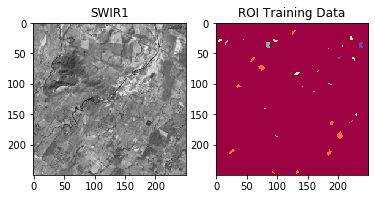

In [48]:
# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [80]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1] * (img.shape[2] - 1))

img_as_array = img[:, :, :7].reshape(new_shape).astype(np.float16)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (250, 250, 8) to (437500,)


In [106]:
start_time = time.time()
img_as_array_f16 = np.array([int(hex(i.view(np.int16)), 0) for i in img_as_array], dtype=np.uint32)
end_time = time.time()

In [107]:
end_time - start_time

9.821214437484741

In [110]:
img_as_array_f16

array([24690, 25324, 25068, ..., 26747, 25621, 26918], dtype=uint32)

In [113]:
s_per_b = 1000
# careful to choose the value so that the input samples fit SAMPLE BUFFER and the output votes fit VOTE BUFFER
if s_per_b*N_ATTR <= SAMPLE_BRAM_ADDRESS_RANGE//4 and s_per_b*N_LABELS <= VOTE_BRAM_ADDRESS_RANGE//4:
    print('valid samples/buffer')
else:
    print('invalid samples/buffer')
    
sample_partitions = np.array_split(img_as_array_f16, list(range(0,len(img_as_array_f16), s_per_b*N_ATTR))[1:])

valid samples/buffer


In [114]:
sample_partitions

[array([24690, 25324, 25068, ..., 26367, 25006, 26818], dtype=uint32),
 array([24768, 25408, 25258, ..., 26660, 25324, 26894], dtype=uint32),
 array([24596, 25232, 25218, ..., 26115, 24846, 26868], dtype=uint32),
 array([24678, 25230, 25100, ..., 26544, 25164, 26868], dtype=uint32),
 array([24264, 24920, 24460, ..., 26710, 25482, 26918], dtype=uint32),
 array([24586, 25226, 25060, ..., 26216, 24794, 26894], dtype=uint32),
 array([24624, 25092, 24980, ..., 27012, 26016, 27041], dtype=uint32),
 array([24620, 24958, 24938, ..., 27124, 26228, 27090], dtype=uint32),
 array([24662, 25002, 24978, ..., 26798, 25911, 27041], dtype=uint32),
 array([24786, 25352, 25210, ..., 26418, 25112, 26918], dtype=uint32),
 array([24224, 24732, 24440, ..., 26191, 24900, 26894], dtype=uint32),
 array([24612, 24952, 24818, ..., 26342, 25112, 26844], dtype=uint32),
 array([24300, 24818, 24624, ..., 26317, 25006, 26844], dtype=uint32),
 array([24556, 25082, 24934, ..., 26267, 24900, 26868], dtype=uint32),
 array

In [115]:
def vote_summary(vote_list, n_samples, n_labels, labels):
    pred_list = []
    for s in range(n_samples):
        sample_idx = s*n_labels
        larges_label_idx = 0
        for l in range(1,n_labels):
            if vote_list[sample_idx + l] > vote_list[sample_idx + larges_label_idx]:
                larges_label_idx = l
        pred_list.append(labels[larges_label_idx])
    return pred_list

In [116]:
# start timer
start_time = time.time()
class_prediction = []

# transfer decision rules
transfer(cdma, dtp_buffer_cdma_in.physical_address, DTP_BRAM_BASE_ADDRESS[0], DTP_BRAM_ADDRESS_RANGE[0]*N_DTPS)

# sample buffer
img_buffer = allocate(shape=(SAMPLE_BRAM_ADDRESS_RANGE//4,), dtype=np.uint32)

for partition in sample_partitions: # number of experiments
    # config number of samples
    regsbank_mmio.write(4*SAMP_THSH_REG_IDX, len(partition)-1)
#     print_reg()
    
    # prepare samples
    img_buffer[:len(partition)] = partition
    
    # transfer samples
    transfer(cdma, img_buffer.physical_address, SAMPLE_BRAM_BASE_ADDRESS, SAMPLE_BRAM_ADDRESS_RANGE)
    
#     time.sleep(0.5)
    
    # start core
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 1)
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_START_CORE_IDX, 0)
    
    # wait until core is done
    while(read_bit(regsbank_mmio,4*STT_REG_IDX,STT_REG_DTP_FIN_IDX) == 0):
        pass
    
    # read output result
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 1) # reading mode ON
    transfer(cdma, VOTE_BRAM_BASE_ADDRESS, vote_buffer_cdma_out.physical_address, VOTE_BRAM_ADDRESS_RANGE) # transfer to all DTPs
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_IS_PS_READ_IDX, 0) # reading mode OFF
    
#     for i in vote_buffer_cdma_out:
#         print(i)
    
    # vote summary
    
    class_prediction.extend(vote_summary(vote_buffer_cdma_out, len(partition)//N_ATTR, N_LABELS, CLASSES))
 
    # reset core
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 1)
    write_bit(regsbank_mmio, 4*CTRL_REG_IDX, CTRL_REG_END_CORE_IDX, 0)
    
    while(read_bit(regsbank_mmio,4*STT_REG_IDX,STT_REG_DTP_FIN_IDX) == 1):
        pass
    
# end timer
end_time = time.time()   

In [117]:
end_time-start_time

2.207637071609497

In [118]:
len(class_prediction)

62500

In [119]:
class_prediction

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [120]:
class_prediction = np.array(class_prediction)

In [121]:
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

In [124]:
# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors

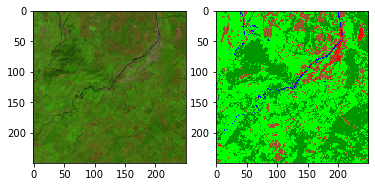

In [125]:
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()